## University of Wisconsin at Madison Examination of Grade Distributions 

2. Did large classes (more than 32 students, which is the 75th percentile of enrollment) had different grade distribution than smaller classes, 

### Load the data and needed libraries

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
from scipy.stats import ttest_ind
import scipy.stats as stats

In [149]:
conn = sqlite3.connect('uw-madison-courses/database.sqlite3')

In [150]:
c = conn.cursor()
c.execute("""SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE "sqlite%";""").fetchall()


[('sections',),
 ('instructors',),
 ('course_offerings',),
 ('subject_memberships',),
 ('courses',),
 ('rooms',),
 ('teachings',),
 ('subjects',),
 ('schedules',),
 ('grade_distributions',),
 ('terms',)]

In [151]:
c.execute('PRAGMA table_info(schedules)').fetchall()

[(0, 'uuid', 'TEXT', 0, None, 0),
 (1, 'start_time', 'TEXT', 0, None, 0),
 (2, 'end_time', 'TEXT', 0, None, 0),
 (3, 'mon', 'TEXT', 0, None, 0),
 (4, 'tues', 'TEXT', 0, None, 0),
 (5, 'wed', 'TEXT', 0, None, 0),
 (6, 'thurs', 'TEXT', 0, None, 0),
 (7, 'fri', 'TEXT', 0, None, 0),
 (8, 'sat', 'TEXT', 0, None, 0),
 (9, 'sun', 'TEXT', 0, None, 0)]

In [152]:
c.execute('PRAGMA table_info(course_offerings)').fetchall()

[(0, 'uuid', 'TEXT', 0, None, 0),
 (1, 'course_uuid', 'TEXT', 0, None, 0),
 (2, 'term_code', 'TEXT', 0, None, 0),
 (3, 'name', 'TEXT', 0, None, 0)]

In [153]:
c.execute('PRAGMA table_info(sections)').fetchall()

[(0, 'uuid', 'TEXT', 0, None, 0),
 (1, 'course_offering_uuid', 'TEXT', 0, None, 0),
 (2, 'section_type', 'TEXT', 0, None, 0),
 (3, 'number', 'TEXT', 0, None, 0),
 (4, 'room_uuid', 'TEXT', 0, None, 0),
 (5, 'schedule_uuid', 'TEXT', 0, None, 0)]

In [154]:
df = pd.DataFrame(c.execute("""
SELECT * FROM grade_distributions AS gd, course_offerings AS co,
sections s, schedules sch
WHERE co.uuid = gd.course_offering_uuid
and s.course_offering_uuid = co.uuid
and sch.uuid = s.schedule_uuid
;""").fetchall())
df.columns = [i[0] for i in c.description]
df.head()

,course_offering_uuid,section_number,n_count,c_count,f_count,cr_count,p_count,nw_count,other_count,bc_count,...,uuid,start_time,end_time,mon,tues,wed,thurs,fri,sat,sun
0,344b3ebe-da7e-314c-83ed-9425269695fd,1,0,0,0,0,0,0,0,0,...,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1,-1,false,false,false,false,false,false,false
1,f718e6cd-33f0-3c14-a9a6-834d9c3610a8,1,0,0,0,0,0,0,0,0,...,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1,-1,false,false,false,false,false,false,false
2,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,...,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1,-1,false,false,false,false,false,false,false
3,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,...,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1,-1,false,false,false,false,false,false,false
4,ea3b717c-d66b-30dc-8b37-964d9688295f,1,0,3,0,0,0,0,0,0,...,f2d66a4d-0c08-3b48-abf6-649fffd7ae90,-1,-1,false,false,false,false,false,false,false


In [155]:
df.columns

Index(['course_offering_uuid', 'section_number', 'n_count', 'c_count',
       'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count',
       'u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count',
       'b_count', 'nr_count', 'uuid', 'course_uuid', 'term_code', 'name',
       'uuid', 'course_offering_uuid', 'section_type', 'number', 'room_uuid',
       'schedule_uuid', 'uuid', 'start_time', 'end_time', 'mon', 'tues', 'wed',
       'thurs', 'fri', 'sat', 'sun'],
      dtype='object')

### Exploratory Data Analysis of Question 2 - Do early classes have different grade distributions

In [156]:
#Class grade counts were saved as text, converted to numbers
df[['n_count', 'c_count', 'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count', 'u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count', 'b_count', 'nr_count']] = df[['n_count', 'c_count', 'f_count', 'cr_count', 'p_count', 'nw_count', 'other_count', 'bc_count','u_count', 'd_count', 'ab_count', 'a_count', 's_count', 'i_count',
       'b_count', 'nr_count']].astype(int)
    

In [157]:
#Create class enrollment feature, sum of all grade counts. Excluded all non-grade counts,
#(satisfactory, unsatisfactory, credit, no credit, progress, incomplete, and no report)
df['enrollment'] = df[['c_count', 'nw_count', 'f_count', 'bc_count', 'd_count', 'ab_count', 
                       'a_count', 'b_count']].sum(axis = 1)
df['enrollment'].head()

0    105
1    158
2    156
3    156
4    156
Name: enrollment, dtype: int64

In [158]:
#More than 100,000 or 52% classes have zero grades, which is the proxy for class enrollment. 
#The class with the most zero-grades is Research (13,074), and other research/thesis classes 
#are at the top. The bottom lists more unique classes like Thai Poetry that only have one or two empty classes.

df['enrollment'].value_counts().head()

0     1320124
19      42714
13      40997
18      39605
17      34846
Name: enrollment, dtype: int64

In [159]:
df['cum_grade'] = df['a_count'] * 4 + df['ab_count'] * 3.5 + df['b_count'] * 3.0 + df['bc_count'] * 2.5 \
+ df['c_count'] * 2.0 + df['d_count'] * 1 + df['f_count'] * 0


In [160]:
df['class_gpa'] = df['cum_grade'] / df['enrollment']

In [161]:
df['weighted_gpa'] = df['cum_grade'] / (df['enrollment']**2)

In [162]:
df["start_time"] = df["start_time"].astype(int)

In [163]:
# convert minutes to hours
df['start_time_hour'] = round(df["start_time"]/60,2)

In [164]:
df['start_time_hour'].unique()[0:20]

array([-2.000e-02,  8.830e+00,  1.100e+01,  1.333e+01,  1.208e+01,
        1.442e+01,  9.920e+00,  1.550e+01,  1.450e+01,  1.733e+01,
        1.658e+01,  1.750e+01,  1.600e+01,  1.558e+01,  1.200e+01,
        1.900e+01,  1.575e+01,  1.950e+01,  1.850e+01,  2.025e+01])

In [165]:
df["a_count_pct"] = df["a_count"]/df["enrollment"]
df["ab_count_pct"] = df["ab_count"]/df["enrollment"]
df["b_count_pct"] = df["b_count"]/df["enrollment"]
df["f_count_pct"] = df["f_count"]/df["enrollment"]

In [166]:
# getting rid of some odd (n/a?) values for start time
df = df[df["start_time"] !=-1]

In [167]:
# removing n/as
df = df[df["start_time_hour"].notna()]
df = df[df["class_gpa"].notna()]

In [168]:
# Early classes are defined as before noon, Late classes after that
df_early_class = df[df['start_time_hour'] >= 12]
df_late_class = df[(df['start_time_hour'] < 12) ]

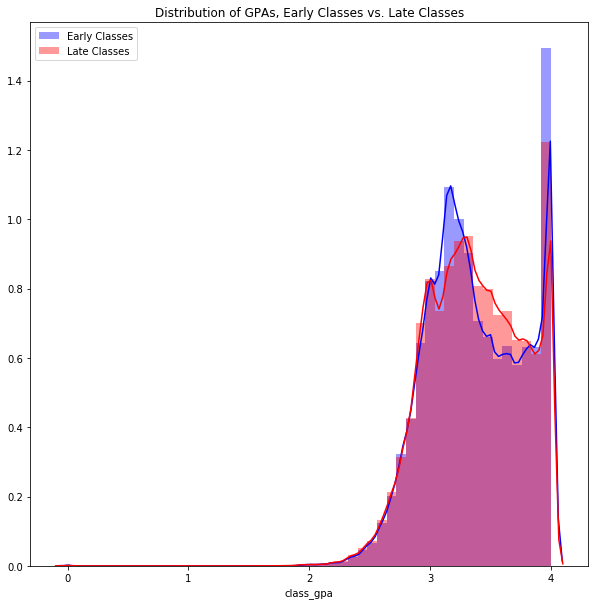

In [169]:
# Plot the distributions. They seem to map each other quite well
fig = plt.figure(figsize=(10,10))
plt.title("Distribution of GPAs, Early Classes vs. Late Classes")
sns.distplot(df_early_class['class_gpa'], color = 'blue', label="Early Classes")
sns.distplot(df_late_class['class_gpa'], color = 'red', label="Late Classes")
plt.legend()

In [170]:
# T-statistic and p-value
ttest_ind(df_early_class['class_gpa'], df_late_class['class_gpa'], equal_var=False)

Ttest_indResult(statistic=3.931136880881443, pvalue=8.455395285278649e-05)

In [171]:
# Manually calculating T instead. This seems more reasonable

early = df_early_class['class_gpa']
late = df_late_class['class_gpa']

def t_calc(x, y):
    return (x.mean() - y.mean()) \
/  (len(x) *  np.std(x) + len(y) * np.std(y) \
/  (len(x)  +  len(y)  - 2))
t_val = t_calc(early, late)
t_val

2.277801471299478e-08

In [172]:
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / math.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
print(cohen_d(early, late))

0.0094486983472692


In [173]:
# Power calculation is very high. Low chance of false negative
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()
power_analysis.solve_power(t_val, alpha=.05, power=.8)

3.0255541125681388e+16

# T is small, 

In [174]:
# What about really early classes? Before 8.
df_early_class2 = df[df['start_time_hour'] >= 8]
df_late_class2 = df[(df['start_time_hour'] < 8) ]

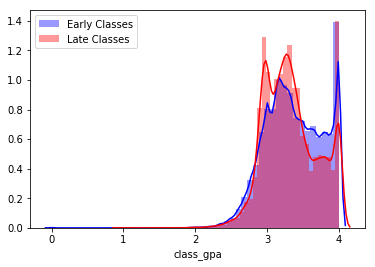

In [175]:
#Larger classes have significantly lower grades than smaller classes. 
sns.distplot(df_early_class2['class_gpa'], color = 'blue', label="Early Classes")
sns.distplot(df_late_class2['class_gpa'], color = 'red', label="Late Classes")
plt.legend()

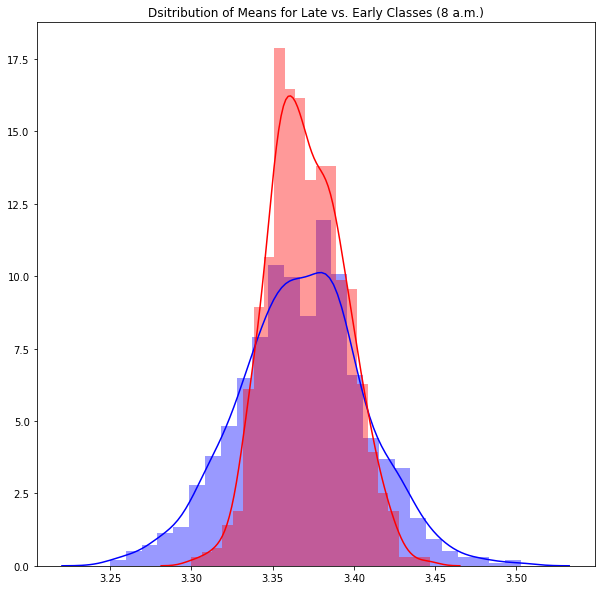

In [179]:
fig  = plt.figure(figsize=(10,10))
early_samples = []
late_samples = []
for i in range(1000):
    sample1 = df_early_class2.sample(300, replace=True)
    sample1['sample_gpa'] = sample1['cum_grade']/sample1['enrollment']
        
    early_samples.append(sample1['sample_gpa'].mean())
    
    sample2 = df_late_class.sample(100, replace=True)
    sample2['sample_gpa'] = sample2['cum_grade']/sample2['enrollment']
    late_samples.append(sample2['sample_gpa'].mean())

plt.title("Dsitribution of Means for Late vs. Early Classes (8 a.m.)")
sns.distplot(late_samples, color="blue")
sns.distplot(early_samples, color="red")


In [100]:
ttest_ind(df_early_class2['class_gpa'], df_late_class2['class_gpa'], equal_var=False)

Ttest_indResult(statistic=22.073150991016824, pvalue=3.106564524038498e-107)

In [109]:
def t_calc(x, y):
    return (x.mean() - y.mean()) \
/  (len(x) *  np.std(x) + len(y) * np.std(y) \
/  (len(x)  +  len(y)  - 2))

In [114]:
early = df_early_class2['class_gpa']
late = df_late_class2['class_gpa']

t_val = t_calc(early, late)
t_val

1.7646909434345086e-07

In [116]:
from scipy import stats
df = 100 - 1

norm_p = stats.norm.ppf(.05)

norm_t = stats.norm.ppf(t_val)
print(norm_p, norm_t)

-1.6448536269514729 -5.092733202690166
